<a href="https://colab.research.google.com/github/Patricup/UAS_BIG_DATA_ANALYTICS/blob/main/UAS_BIG_ANALYTICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LINK DATA SET : https://www.kaggle.com/datasets/clairvoyant69/tv-shows-dataset-2021-2024

#LIBRARY

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from sklearn.impute import KNNImputer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import BisectingKMeans


**Preprocessing**

+--------------------+-----------------+------------------+----------+------------+----------+----------------+--------------+---+
|                name|number_of_seasons|number_of_episodes|vote_count|vote_average|popularity|episode_run_time|first_air_date| id|
+--------------------+-----------------+------------------+----------+------------+----------+----------------+--------------+---+
|          Squid Game|                2|                 9|     13053|       7.831|   115.587|               0|     9/17/2021|  1|
|         WandaVision|                1|                 9|     11308|         8.3|    62.893|               0|     1/15/2021|  2|
|                Loki|                2|                12|     10136|         8.2|   276.759|              52|      6/9/2021|  3|
|The Falcon and th...|                1|                 6|      8008|       7.693|    35.521|              50|     3/19/2021|  4|
|           Wednesday|                2|                 8|      7506|       8.548|

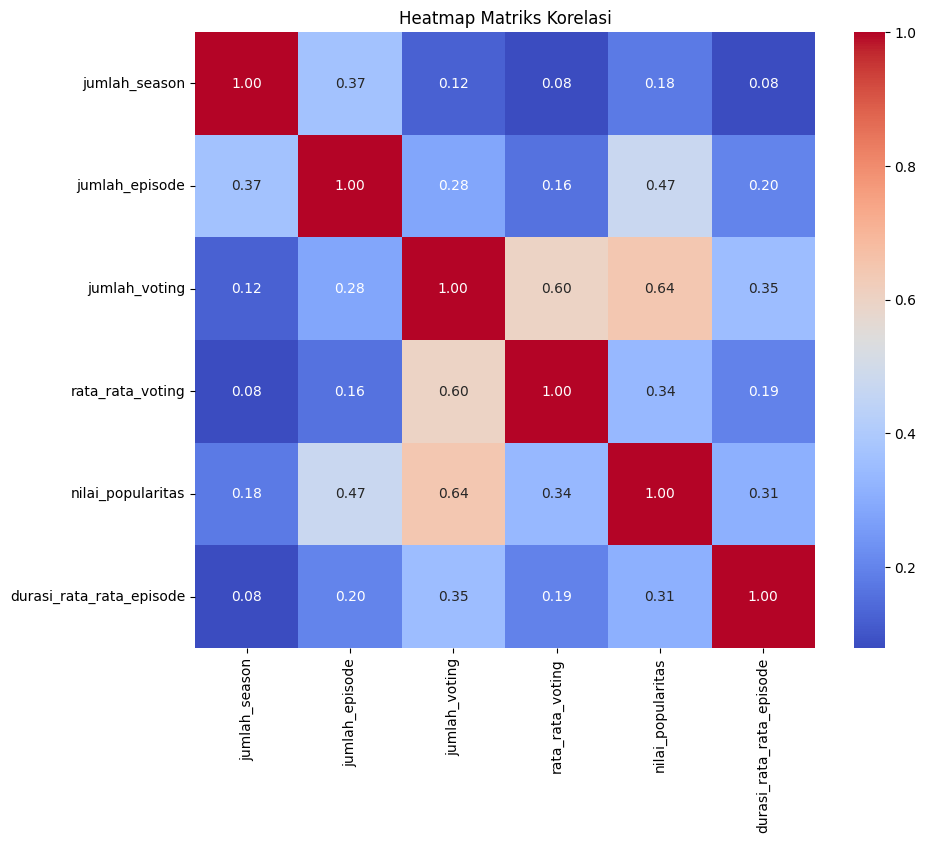

In [ ]:

#inisialisasi session
spark = SparkSession.builder.appName("PreprocessingTVData").getOrCreate()

#load dataset
file_path = "tv.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

df.show()

#cek tipe data
print("Tipe data setiap kolom:")
df.printSchema()

#ubah tipe data kolom dan ubah nama kolom
df = df.withColumn("jumlah_season", col("number_of_seasons").cast("double")) \
       .withColumn("tanggal_tayang_awal", col("first_air_date").cast("float")) \
       .withColumn("jumlah_episode", col("number_of_episodes").cast("double")) \
       .withColumn("jumlah_voting", col("vote_count").cast("double")) \
       .withColumn("rata_rata_voting", col("vote_average").cast("double")) \
       .withColumn("nilai_popularitas", col("popularity").cast("double")) \
       .withColumn("durasi_rata_rata_episode", col("episode_run_time").cast("double"))

#hapus kolom yang namanya sudah diganti
df = df.drop("number_of_seasons", "number_of_episodes", "vote_count", "vote_average", "popularity", "episode_run_time", "first_air_date")

#cek perubahan nama kolom
print("Tipe data setelah penggantian nama kolom:")
df.printSchema()

#cek nilai null
jumlah_null = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
print("Jumlah nilai null per kolom:")
jumlah_null.show()

#ringkasan kolom numerik
kolom_numerik = ['jumlah_season', 'jumlah_episode', 'jumlah_voting', 'rata_rata_voting', 'nilai_popularitas', 'durasi_rata_rata_episode']

#summary
df.describe(kolom_numerik).show()

#konversi ke pandas
df_pd = df.select(kolom_numerik).toPandas()

#hitung matriks korelasi
matriks_korelasi = df_pd.corr(method='spearman')

#tampilkan korelasi
print("Matriks Korelasi:")
print(matriks_korelasi)

#visualisasi menggunakan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matriks_korelasi, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=kolom_numerik, yticklabels=kolom_numerik)
plt.title('Heatmap Matriks Korelasi')
plt.show()


#VISUALISASI PIE,BAR,HISTO, DAN SCATTER

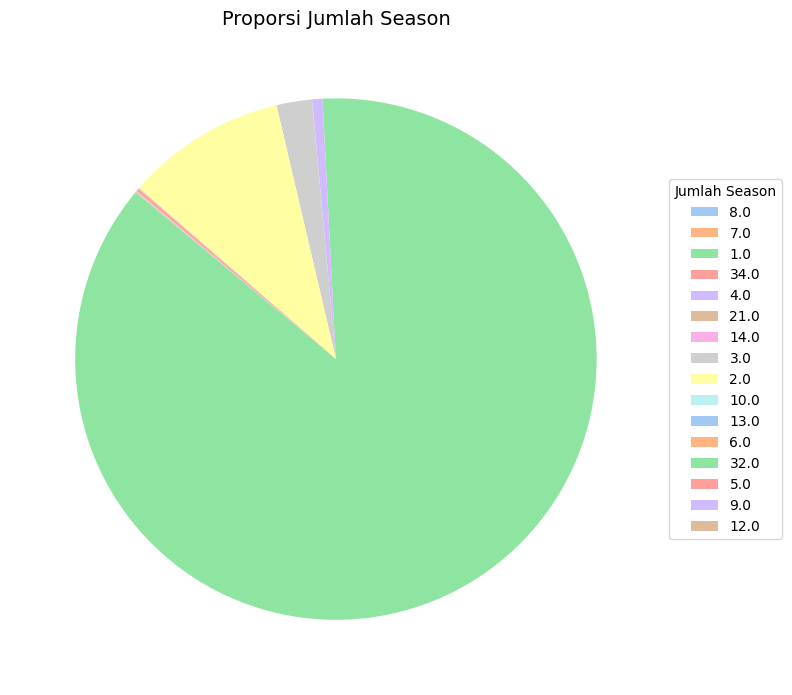

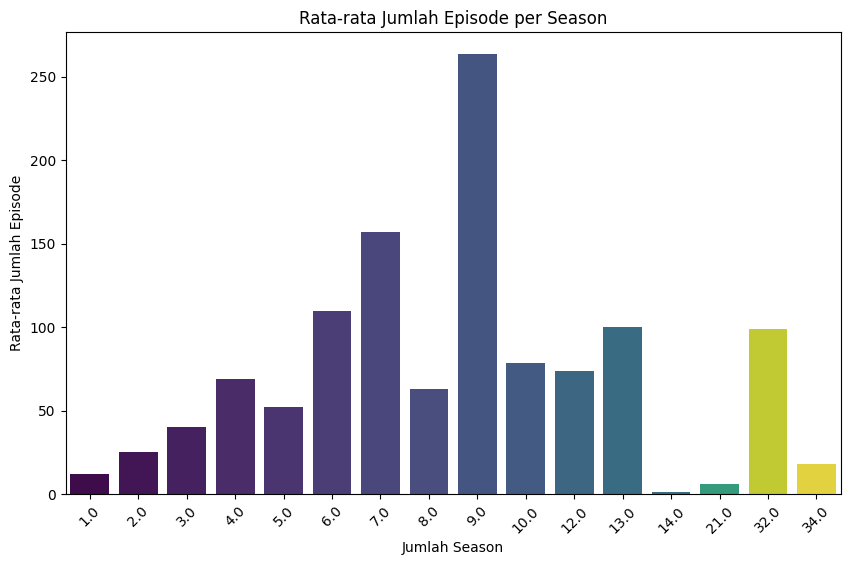

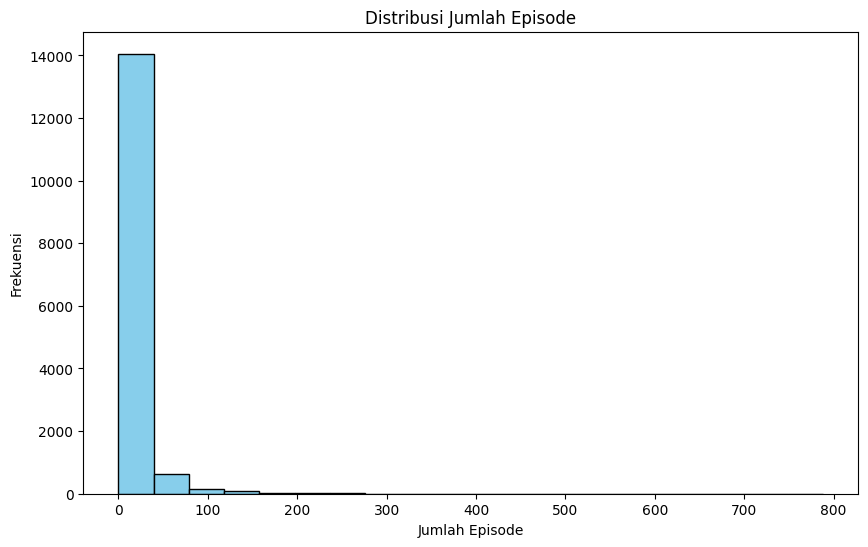

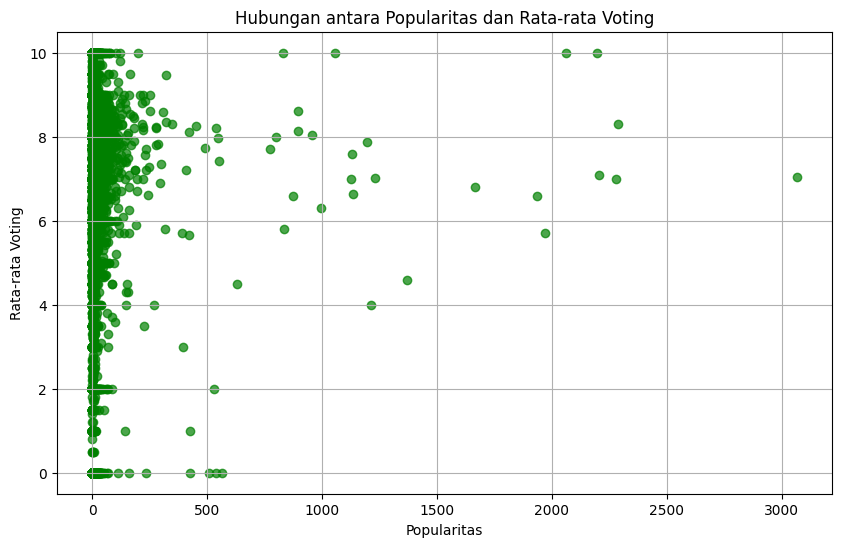

In [ ]:
from pyspark.sql.functions import count, col

# Dataframe yang sudah diproses menjadi pandas
jumlah_season_pd = df.select("jumlah_season").groupBy("jumlah_season").count().toPandas()
# Pie chart tanpa persentase
plt.figure(figsize=(8, 8))
wedges, texts = plt.pie(
    jumlah_season_pd["count"],
    labels=None,  # Tidak menampilkan label di chart
    startangle=140,
    colors=sns.color_palette("pastel")
)
# Menambahkan legenda dengan keterangan warna
plt.legend(
    wedges,
    jumlah_season_pd["jumlah_season"],
    title="Jumlah Season",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10
)
# Judul chart
plt.title("Proporsi Jumlah Season", fontsize=14)
plt.tight_layout()
plt.show()
print("")

# Bar chart untuk jumlah episode per season
jumlah_episode_pd = df.select("jumlah_season", "jumlah_episode").groupBy("jumlah_season").mean("jumlah_episode").orderBy("jumlah_season").toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="jumlah_season", y="avg(jumlah_episode)", data=jumlah_episode_pd,
            hue="jumlah_season", palette="viridis", legend=False)  # Menambahkan hue
plt.title("Rata-rata Jumlah Episode per Season")
plt.xlabel("Jumlah Season")
plt.ylabel("Rata-rata Jumlah Episode")
plt.xticks(rotation=45)
plt.show()

print("")
# Histogram untuk distribusi jumlah episode
plt.figure(figsize=(10, 6))
plt.hist(df_pd['jumlah_episode'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribusi Jumlah Episode')
plt.xlabel('Jumlah Episode')
plt.ylabel('Frekuensi')
plt.show()
print("")
# Scatter plot untuk hubungan antara popularitas dan rata-rata voting
plt.figure(figsize=(10, 6))
plt.scatter(
    df_pd['nilai_popularitas'],
    df_pd['rata_rata_voting'],
    alpha=0.7,
    color='green'
)
plt.title('Hubungan antara Popularitas dan Rata-rata Voting')
plt.xlabel('Popularitas')
plt.ylabel('Rata-rata Voting')
plt.grid(True)
plt.show()





**Modeling**

**Klasifikasi (Gradient Boost Tree & Random Forest)**

GBT Model - AUC: 86.66%
GBT Model - Accuracy: 89.39%
GBT Model - F1 Score: 59.04%
GBT Model - Precision: 78.01%
GBT Model - Recall: 47.49%
Random Forest Model - AUC: 86.98%
Random Forest Model - Accuracy: 89.35%
Random Forest Model - F1 Score: 59.07%
Random Forest Model - Precision: 77.55%
Random Forest Model - Recall: 47.70%


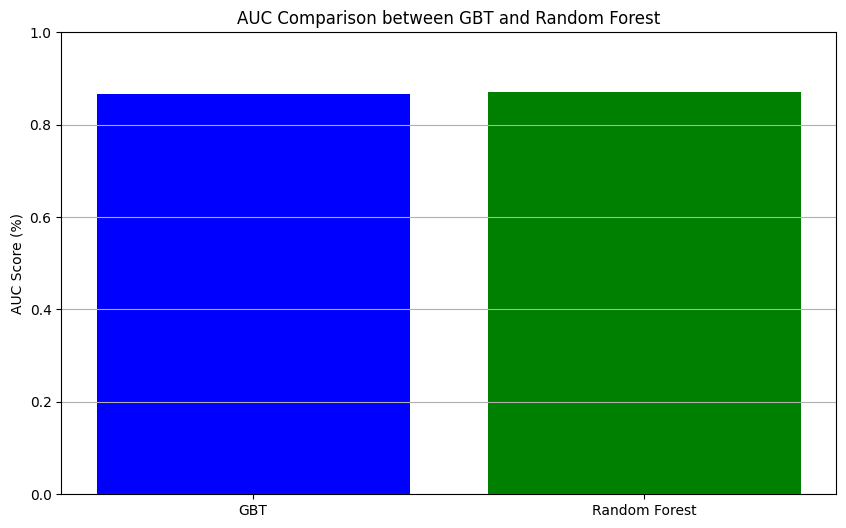

In [ ]:
#klasifikasi Klasifikasi (Gradient Boost Tree & Random Forest)
# 1. Pilih fitur yang akan digunakan (misalnya, vote_count, number_of_episodes, dll.)
feature_columns = ['jumlah_voting', 'jumlah_episode', 'rata_rata_voting', 'durasi_rata_rata_episode', 'jumlah_season']
target_column = 'nilai_popularitas'

# 2. Tentukan ambang batas untuk popularitas
popularity_mean = df.select(F.mean('nilai_popularitas')).first()[0]

# Ubah target 'popularity' menjadi biner (1 jika lebih besar dari rata-rata, 0 jika lebih kecil atau sama dengan rata-rata)
df = df.withColumn(target_column, F.when(F.col(target_column) > popularity_mean, 1).otherwise(0))

# 3. Persiapkan data untuk model
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# 4. Bagi data menjadi data pelatihan dan data pengujian (80-20 split)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

#model gradient boost tree
gbt = GBTClassifier(labelCol=target_column, featuresCol="features", maxIter=10)

#model random forest
rf = RandomForestClassifier(labelCol=target_column, featuresCol="features", numTrees=200, maxDepth=10, minInstancesPerNode=5)

# 6. Evaluasi model (menggunakan AUC dan metrik lainnya)
evaluator = BinaryClassificationEvaluator(labelCol=target_column, metricName="areaUnderROC")

# 7. Pipeline untuk GBT
gbt_pipeline = Pipeline(stages=[assembler, gbt])
gbt_model = gbt_pipeline.fit(train_data)

# 8. Pipeline untuk Random Forest
rf_pipeline = Pipeline(stages=[assembler, rf])
rf_model = rf_pipeline.fit(train_data)

# 9. Prediksi menggunakan model GBT dan Random Forest
gbt_predictions = gbt_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)

# 10. Evaluasi AUC
gbt_auc = evaluator.evaluate(gbt_predictions)
rf_auc = evaluator.evaluate(rf_predictions)

# 11. Hitung metrik lainnya untuk GBT
gbt_results = gbt_predictions.select("prediction", target_column)
gbt_tp = gbt_results.filter((gbt_results.prediction == 1) & (gbt_results[target_column] == 1)).count()
gbt_tn = gbt_results.filter((gbt_results.prediction == 0) & (gbt_results[target_column] == 0)).count()
gbt_fp = gbt_results.filter((gbt_results.prediction == 1) & (gbt_results[target_column] == 0)).count()
gbt_fn = gbt_results.filter((gbt_results.prediction == 0) & (gbt_results[target_column] == 1)).count()
gbt_accuracy = (gbt_tp + gbt_tn) / gbt_results.count() * 100
gbt_precision = gbt_tp / (gbt_tp + gbt_fp) * 100 if (gbt_tp + gbt_fp) > 0 else 0
gbt_recall = gbt_tp / (gbt_tp + gbt_fn) * 100 if (gbt_tp + gbt_fn) > 0 else 0
gbt_f1 = 2 * (gbt_precision * gbt_recall) / (gbt_precision + gbt_recall) if (gbt_precision + gbt_recall) > 0 else 0

# 12. Hitung metrik lainnya untuk Random Forest
rf_results = rf_predictions.select("prediction", target_column)
rf_tp = rf_results.filter((rf_results.prediction == 1) & (rf_results[target_column] == 1)).count()
rf_tn = rf_results.filter((rf_results.prediction == 0) & (rf_results[target_column] == 0)).count()
rf_fp = rf_results.filter((rf_results.prediction == 1) & (rf_results[target_column] == 0)).count()
rf_fn = rf_results.filter((rf_results.prediction == 0) & (rf_results[target_column] == 1)).count()
rf_accuracy = (rf_tp + rf_tn) / rf_results.count() * 100
rf_precision = rf_tp / (rf_tp + rf_fp) * 100 if (rf_tp + rf_fp) > 0 else 0
rf_recall = rf_tp / (rf_tp + rf_fn) * 100 if (rf_tp + rf_fn) > 0 else 0
rf_f1 = 2 * (rf_precision * rf_recall) / (rf_precision + rf_recall) if (rf_precision + rf_recall) > 0 else 0

# 13. Menampilkan hasil evaluasi
print(f"GBT Model - AUC: {gbt_auc:.2%}")
print(f"GBT Model - Accuracy: {gbt_accuracy:.2f}%")
print(f"GBT Model - F1 Score: {gbt_f1:.2f}%")
print(f"GBT Model - Precision: {gbt_precision:.2f}%")
print(f"GBT Model - Recall: {gbt_recall:.2f}%")

print(f"Random Forest Model - AUC: {rf_auc:.2%}")
print(f"Random Forest Model - Accuracy: {rf_accuracy:.2f}%")
print(f"Random Forest Model - F1 Score: {rf_f1:.2f}%")
print(f"Random Forest Model - Precision: {rf_precision:.2f}%")
print(f"Random Forest Model - Recall: {rf_recall:.2f}%")

# 14. Visualisasi AUC untuk GBT dan Random Forest
fig, ax = plt.subplots(figsize=(10, 6))
models = ['GBT', 'Random Forest']
auc_scores = [gbt_auc, rf_auc]

ax.bar(models, auc_scores, color=['blue', 'green'])
ax.set_ylabel('AUC Score (%)')
ax.set_title('AUC Comparison between GBT and Random Forest')
ax.set_ylim(0, 1.0)
ax.set_xticks(range(len(models)), labels=models)
plt.grid(axis="y")
plt.show()


K-Means & Bisecting K-Means

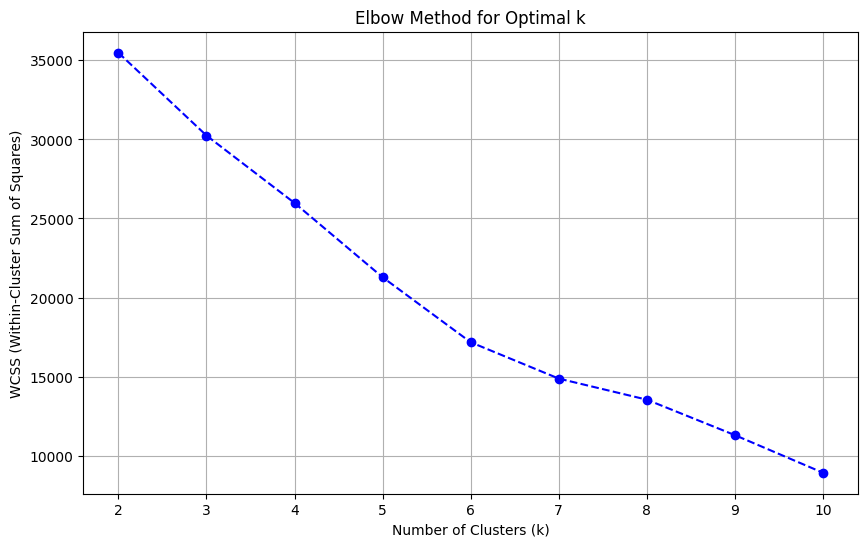

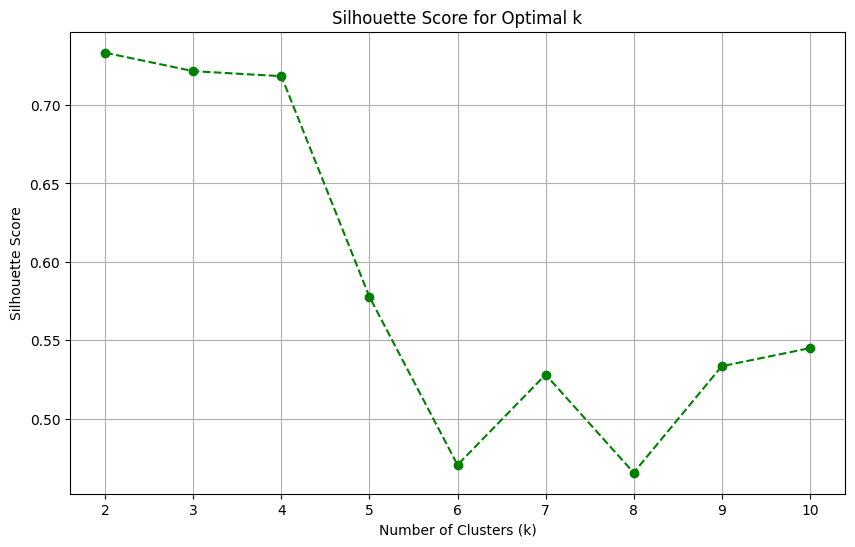

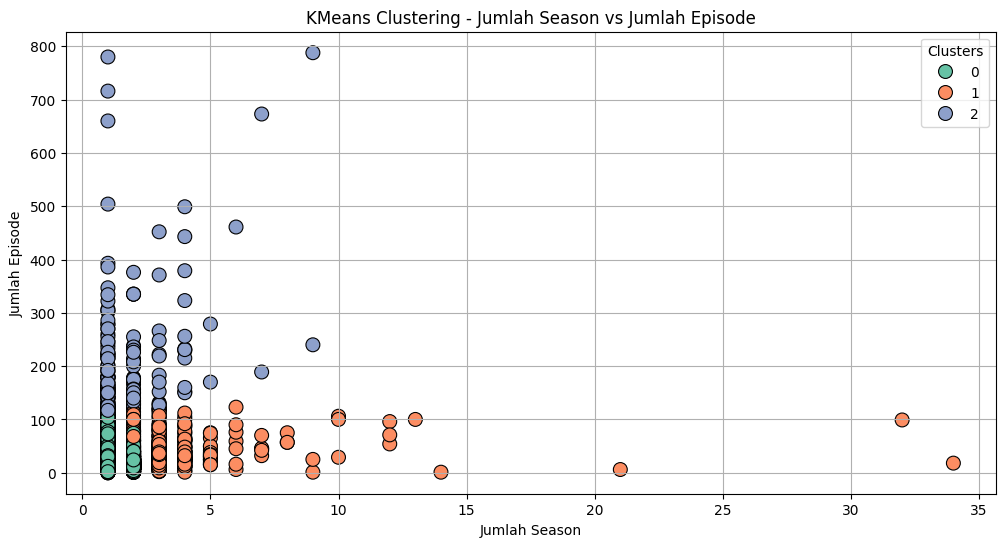

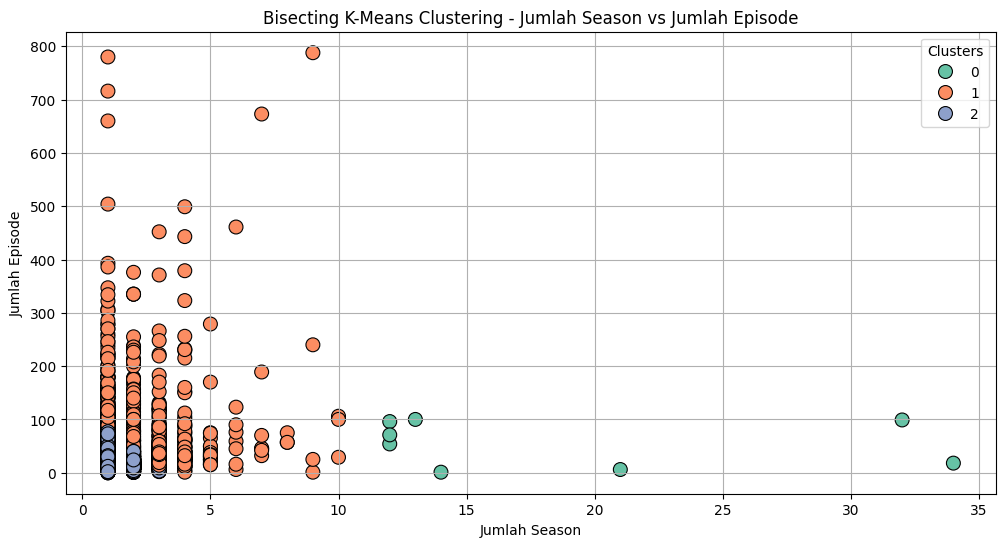


Silhouette Score for KMeans: 0.7216604240636709

Silhouette Score for Bisecting K-Means: 0.7214943465378515


In [ ]:

# 1. Pilih fitur yang akan digunakan untuk clustering
feature_columns = ['jumlah_season', 'jumlah_episode']

# 2. Cek apakah kolom 'features' sudah ada, jika ada hapus
if "features" in df.columns:
    df = df.drop("features")

# 3. Persiapkan data untuk clustering
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_with_features = assembler.transform(df)

# Menghitung rata-rata `popularity` untuk menentukan ambang batas
popularity_mean = df.select(F.mean('nilai_popularitas')).first()[0]

# 4. Menambahkan kolom 'is_popular' berdasarkan nilai 'popularity'
df = df.withColumn("is_popular", F.when(F.col("nilai_popularitas") > popularity_mean, 1).otherwise(0))

# 5. Convert Spark DataFrame ke Pandas DataFrame agar kompatibel dengan scikit-learn
df_pd = df_with_features.select('jumlah_season', 'jumlah_episode', 'durasi_rata_rata_episode').toPandas()

# 6. Standardisasi data untuk clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pd)

# 7. Cari k optimal menggunakan metode Elbow
wcss = []  # Within-Cluster Sum of Squares
range_k = range(2, 11)  # Range k dari 2 hingga 10
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)
print("")
# Visualisasi Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range_k, wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range_k)
plt.grid()
plt.show()
print("")
# 8. Cari k optimal menggunakan Silhouette Score
silhouette_scores = []
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, labels))

# Visualisasi Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(range_k, silhouette_scores, marker='o', linestyle='--', color='g')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range_k)
plt.grid()
plt.show()
print("")
# 9. Lakukan clustering menggunakan KMeans dengan k optimal (misalnya k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)
print("")
# 10. Bisecting K-Means Clustering (gunakan k=3 untuk konsistensi)
bisecting_kmeans = BisectingKMeans(n_clusters=3, random_state=42)
bisecting_kmeans_labels = bisecting_kmeans.fit_predict(df_scaled)
print("")
# 11. Menambahkan hasil clustering ke DataFrame
df_pd['kmeans_cluster'] = kmeans_labels
df_pd['bisecting_kmeans_cluster'] = bisecting_kmeans_labels
print("")
# 12. Visualisasi KMeans Clustering
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_pd['jumlah_season'], y=df_pd['jumlah_episode'], hue=df_pd['kmeans_cluster'], palette="Set2", s=100, edgecolor='black')
plt.title("KMeans Clustering - Jumlah Season vs Jumlah Episode")
plt.xlabel('Jumlah Season')
plt.ylabel('Jumlah Episode')
plt.legend(title="Clusters")
plt.grid()
plt.show()
print("")
# 13. Visualisasi Bisecting K-Means Clustering
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_pd['jumlah_season'], y=df_pd['jumlah_episode'], hue=df_pd['bisecting_kmeans_cluster'], palette="Set2", s=100, edgecolor='black')
plt.title("Bisecting K-Means Clustering - Jumlah Season vs Jumlah Episode")
plt.xlabel('Jumlah Season')
plt.ylabel('Jumlah Episode')
plt.legend(title="Clusters")
plt.grid()
plt.show()
print("")
# 14. Hitung Silhouette Score untuk KMeans
kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels)
print(f"Silhouette Score for KMeans: {kmeans_silhouette}")
print("")
# 15. Hitung Silhouette Score untuk Bisecting K-Means
bisecting_kmeans_silhouette = silhouette_score(df_scaled, bisecting_kmeans_labels)
print(f"Silhouette Score for Bisecting K-Means: {bisecting_kmeans_silhouette}")


**Hyperparameter Tuning**

**Random Forest**

Best Model AUC: 87.33%
Accuracy: 89.43%
Precision: 76.74%
Recall: 47.53%
F1 Score: 58.70%


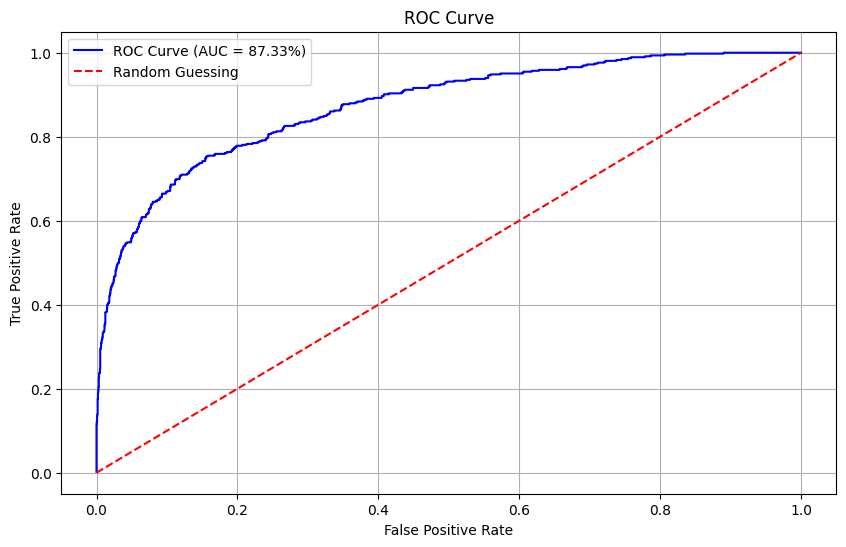

In [ ]:
# hyiperparameter tunning
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

# 1. Pilih fitur yang akan digunakan
feature_columns = ['jumlah_voting', 'jumlah_episode', 'rata_rata_voting', 'durasi_rata_rata_episode', 'jumlah_season']
target_column = 'nilai_popularitas'

if "features" in df.columns:
    df = df.drop("features")

# 2. Ubah target menjadi biner berdasarkan rata-rata
popularity_mean = df.select(F.mean('nilai_popularitas')).first()[0]
df = df.withColumn(target_column, F.when(F.col(target_column) > popularity_mean, 1).otherwise(0))

# 3. Siapkan data
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
rf = RandomForestClassifier(labelCol=target_column, featuresCol="features", seed=42)

# 4. Bagi data menjadi pelatihan dan pengujian
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# 5. Evaluator
evaluator_auc = BinaryClassificationEvaluator(labelCol=target_column, metricName="areaUnderROC")

# 6. Buat pipeline
pipeline = Pipeline(stages=[assembler, rf])

# 7. Grid Search untuk Hyperparameter Tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# 8. Cross Validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_auc,
                          numFolds=2)  # 2-fold cross-validation untuk mempercepat proses

# 9. Latih model
cv_model = crossval.fit(train_data)

# 10. Model terbaik
best_model = cv_model.bestModel
best_rf = best_model.stages[-1]  # Random Forest adalah stage terakhir pada pipeline

# 11. Prediksi pada data uji
predictions = best_model.transform(test_data)

# 12. Evaluasi metrik
auc = evaluator_auc.evaluate(predictions) * 100  # AUC dalam persen

# Hitung metrik lainnya
predictions = predictions.withColumn("prediction", predictions["prediction"].cast(DoubleType()))
tp = predictions.filter((F.col("prediction") == 1) & (F.col(target_column) == 1)).count()
tn = predictions.filter((F.col("prediction") == 0) & (F.col(target_column) == 0)).count()
fp = predictions.filter((F.col("prediction") == 1) & (F.col(target_column) == 0)).count()
fn = predictions.filter((F.col("prediction") == 0) & (F.col(target_column) == 1)).count()

accuracy = (tp + tn) / (tp + tn + fp + fn) * 100
precision = tp / (tp + fp) * 100 if (tp + fp) > 0 else 0
recall = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print hasil evaluasi
print(f"Best Model AUC: {auc:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1_score:.2f}%")

# 13. Visualisasi ROC Curve
roc = predictions.select("probability", target_column).rdd \
    .map(lambda row: (float(row['probability'][1]), float(row[target_column]))) \
    .toDF(["probability", "label"])

roc = roc.orderBy("probability", ascending=False).toPandas()

import numpy as np
roc['tp'] = np.cumsum(roc['label'])
roc['fp'] = np.cumsum(1 - roc['label'])
roc['tpr'] = roc['tp'] / roc['label'].sum()
roc['fpr'] = roc['fp'] / (roc['label'].count() - roc['label'].sum())

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(roc['fpr'], roc['tpr'], label=f"ROC Curve (AUC = {auc:.2f}%)", color='blue')
plt.plot([0, 1], [0, 1], 'r--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


**K-Means**

Best Model -> k: 2, maxIter: 10
Centroids:
Cluster 0: [11.9563307   1.17859799]
Cluster 1: [193.71014493   1.90821256]
Silhouette Score untuk model terbaik: 0.9785


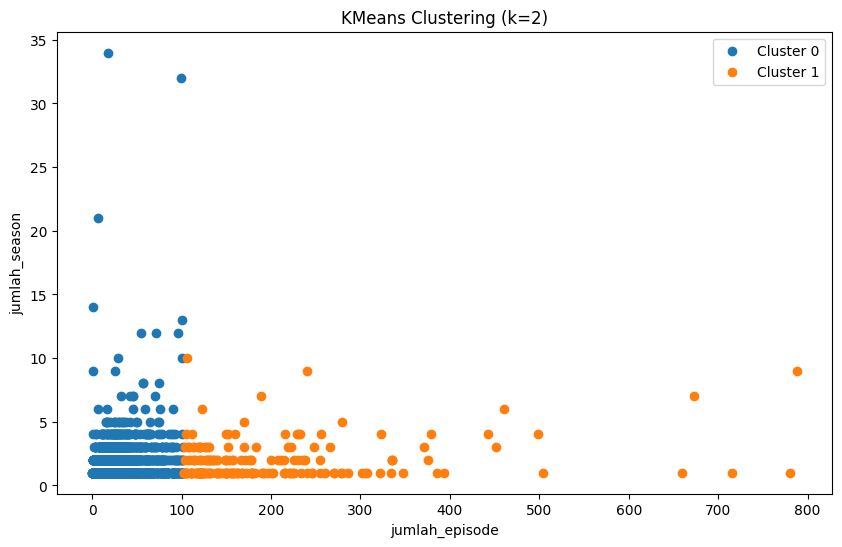

In [ ]:

# Import the correct KMeans class from pyspark.ml.clustering
from pyspark.ml.clustering import KMeans

# 1. Pilih fitur untuk clustering
feature_columns = ['jumlah_episode', 'jumlah_season']

# 2. Siapkan data
if 'features' in df.columns:
    df = df.drop('features')
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

# 3. Evaluator untuk KMeans
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")

# 4. Inisialisasi KMeans
kmeans = KMeans(featuresCol="features", seed=42) # Use the pyspark KMeans class

# 5. Membangun Parameter Grid untuk hyperparameter tuning
param_grid = (ParamGridBuilder()
              .addGrid(kmeans.k, [2, 3, 4, 5])
              .addGrid(kmeans.maxIter, [10, 20, 30])
              .build())

# 6. CrossValidator untuk memilih model terbaik
crossval = CrossValidator(estimator=kmeans,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)  # Tentukan jumlah fold

# 7. Latih model dengan CrossValidator
cv_model = crossval.fit(df)  # Gunakan seluruh data df tanpa sampling

# 8. Pilih model terbaik
best_model = cv_model.bestModel

# 9. Tampilkan model terbaik dan centroids
print(f"Best Model -> k: {best_model.getK()}, maxIter: {best_model.getMaxIter()}")
print("Centroids:")
for idx, centroid in enumerate(best_model.clusterCenters()):
    print(f"Cluster {idx}: {centroid}")

# 10. Menghitung Silhouette Score untuk model terbaik
predictions = best_model.transform(df)
silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette Score untuk model terbaik: {silhouette_score:.4f}")

# 11. Visualisasi hasil (opsional, jika hanya 2 fitur utama)
if len(feature_columns) == 2:
    import matplotlib.pyplot as plt

    # Ambil prediksi untuk visualisasi
    vis_data = best_model.transform(df).select("features", "prediction").toPandas()
    vis_data['x'] = vis_data['features'].apply(lambda v: v[0])
    vis_data['y'] = vis_data['features'].apply(lambda v: v[1])

    # Plot hasil klastering
    plt.figure(figsize=(10, 6))
    for cluster in range(best_model.getK()):
        cluster_data = vis_data[vis_data['prediction'] == cluster]
        plt.scatter(cluster_data['x'], cluster_data['y'], label=f"Cluster {cluster}")
    plt.xlabel(feature_columns[0])
    plt.ylabel(feature_columns[1])
    plt.title(f"KMeans Clustering (k={best_model.getK()})")
    plt.legend()
    plt.show()

    spark.stop()
